# Library Imports and Settings

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
%pip install missingno
import missingno as msno
from datetime import date
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler, RobustScaler
from scipy.stats import norm
from sklearn.impute import KNNImputer
import seaborn as sns

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.width', 500)

# Method Definitions 

In [23]:
#FOR DATASET LOADING
def load():
    data = pd.read_csv("../HPP/test.csv")
    return data

#FOR OUTLIERS
def outlier_thresholds(dataframe, col_name, q1=0.05, q3=0.95):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False

def grab_col_names(dataframe, cat_th=16, car_th=25):
    """

    Veri setindeki kategorik, numerik ve kategorik fakat kardinal değişkenlerin isimlerini verir.
    Not: Kategorik değişkenlerin içerisine numerik görünümlü kategorik değişkenler de dahildir.

    Parameters
    ------
        dataframe: dataframe
                Değişken isimleri alınmak istenilen dataframe
        cat_th: int, optional
                numerik fakat kategorik olan değişkenler için sınıf eşik değeri
        car_th: int, optinal
                kategorik fakat kardinal değişkenler için sınıf eşik değeri

    Returns
    ------
        cat_cols: list
                Kategorik değişken listesi
        num_cols: list
                Numerik değişken listesi
        cat_but_car: list
                Kategorik görünümlü kardinal değişken listesi

    Examples
    ------
        import seaborn as sns
        df = sns.load_dataset("iris")
        print(grab_col_names(df))


    Notes
    ------
        cat_cols + num_cols + cat_but_car = toplam değişken sayısı
        num_but_cat cat_cols'un içerisinde.
        Return olan 3 liste toplamı toplam değişken sayısına eşittir: cat_cols + num_cols + cat_but_car = değişken sayısı

    """

    # cat_cols, cat_but_car
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')
    return cat_cols, num_cols, cat_but_car

def grab_outliers(dataframe, col_name, index=False):
    low, up = outlier_thresholds(dataframe, col_name)

    if dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))].shape[0] > 10:
        print(dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))].head())
    else:
        print(dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))])

    if index:
        outlier_index = dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))].index
        return outlier_index

def remove_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    df_without_outliers = dataframe[~((dataframe[col_name] < low_limit) | (dataframe[col_name] > up_limit))]
    return df_without_outliers

def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

# FOR MISSING VALUES
def missing_values_table(dataframe, na_name=False):
    na_columns = [col for col in dataframe.columns if dataframe[col].isnull().sum() > 0]

    n_miss = dataframe[na_columns].isnull().sum().sort_values(ascending=False)
    ratio = (dataframe[na_columns].isnull().sum() / dataframe.shape[0] * 100).sort_values(ascending=False)
    missing_df = pd.concat([n_miss, np.round(ratio, 2)], axis=1, keys=['n_miss', 'ratio'])
    print(missing_df, end="\n")

    if na_name:
        return na_columns


#FOR ENCODERS
def one_hot_encoder(dataframe, categorical_cols, drop_first=True):
    dataframe = pd.get_dummies(dataframe, columns=categorical_cols, drop_first=drop_first)
    return dataframe

def one_hot_encoder_na_dummy(dataframe, categorical_cols, drop_first=True, dummy_na=True):
    dataframe = pd.get_dummies(dataframe, columns=categorical_cols, drop_first=drop_first, dummy_na = dummy_na)
    return dataframe

def rare_analyser(dataframe, target, cat_cols):
    for col in cat_cols:
        print(col, ":", len(dataframe[col].value_counts()))
        print(pd.DataFrame({"COUNT": dataframe[col].value_counts(),
                            "RATIO": dataframe[col].value_counts() / len(dataframe),
                            "TARGET_MEAN": dataframe.groupby(col)[target].mean()}), end="\n\n\n")

def rare_analyser(dataframe, cat_cols):
    for col in cat_cols:
        print(col, ":", len(dataframe[col].value_counts()))
        print(pd.DataFrame({"COUNT": dataframe[col].value_counts(),
                            "RATIO": dataframe[col].value_counts() / len(dataframe)}), end="\n\n\n")

def rare_encoder(dataframe, rare_perc):
    temp_df = dataframe.copy()

    rare_columns = [col for col in temp_df.columns if temp_df[col].dtypes == 'O'
                    and (temp_df[col].value_counts() / len(temp_df) < rare_perc).any(axis=None)]

    for var in rare_columns:
        tmp = temp_df[var].value_counts() / len(temp_df)
        rare_labels = tmp[tmp < rare_perc].index
        temp_df[var] = np.where(temp_df[var].isin(rare_labels), 'Rare', temp_df[var])

    return temp_df

# Preprocessing

## Dataset Reading

In [13]:
df = load()
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.000,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,NaN,0.000,TA,TA,CBlock,TA,TA,No,Rec,468.000,LwQ,144.000,270.000,882.000,GasA,TA,Y,SBrkr,896,0,0,896,0.000,0.000,1,0,2,1,TA,5,Typ,0,NaN,Attchd,1961.000,Unf,1.000,730.000,TA,TA,Y,140,0,0,0,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.000,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.000,TA,TA,CBlock,TA,TA,No,ALQ,923.000,Unf,0.000,406.000,1329.000,GasA,TA,Y,SBrkr,1329,0,0,1329,0.000,0.000,1,1,3,1,Gd,6,Typ,0,NaN,Attchd,1958.000,Unf,1.000,312.000,TA,TA,Y,393,36,0,0,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.000,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,NaN,0.000,TA,TA,PConc,Gd,TA,No,GLQ,791.000,Unf,0.000,137.000,928.000,GasA,Gd,Y,SBrkr,928,701,0,1629,0.000,0.000,2,1,3,1,TA,6,Typ,1,TA,Attchd,1997.000,Fin,2.000,482.000,TA,TA,Y,212,34,0,0,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.000,9978,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,6,1998,1998,Gable,CompShg,VinylSd,VinylSd,BrkFace,20.000,TA,TA,PConc,TA,TA,No,GLQ,602.000,Unf,0.000,324.000,926.000,GasA,Ex,Y,SBrkr,926,678,0,1604,0.000,0.000,2,1,3,1,Gd,7,Typ,1,Gd,Attchd,1998.000,Fin,2.000,470.000,TA,TA,Y,360,36,0,0,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.000,5005,Pave,NaN,IR1,HLS,AllPub,Inside,Gtl,StoneBr,Norm,Norm,TwnhsE,1Story,8,5,1992,1992,Gable,CompShg,HdBoard,HdBoard,NaN,0.000,Gd,TA,PConc,Gd,TA,No,ALQ,263.000,Unf,0.000,1017.000,1280.000,GasA,Ex,Y,SBrkr,1280,0,0,1280,0.000,0.000,2,0,2,1,Gd,5,Typ,0,NaN,Attchd,1992.000,RFn,2.000,506.000,TA,TA,Y,0,82,0,0,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [14]:
df_copy = df.copy()
df_copy.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.000,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,NaN,0.000,TA,TA,CBlock,TA,TA,No,Rec,468.000,LwQ,144.000,270.000,882.000,GasA,TA,Y,SBrkr,896,0,0,896,0.000,0.000,1,0,2,1,TA,5,Typ,0,NaN,Attchd,1961.000,Unf,1.000,730.000,TA,TA,Y,140,0,0,0,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.000,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.000,TA,TA,CBlock,TA,TA,No,ALQ,923.000,Unf,0.000,406.000,1329.000,GasA,TA,Y,SBrkr,1329,0,0,1329,0.000,0.000,1,1,3,1,Gd,6,Typ,0,NaN,Attchd,1958.000,Unf,1.000,312.000,TA,TA,Y,393,36,0,0,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.000,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,NaN,0.000,TA,TA,PConc,Gd,TA,No,GLQ,791.000,Unf,0.000,137.000,928.000,GasA,Gd,Y,SBrkr,928,701,0,1629,0.000,0.000,2,1,3,1,TA,6,Typ,1,TA,Attchd,1997.000,Fin,2.000,482.000,TA,TA,Y,212,34,0,0,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.000,9978,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,6,1998,1998,Gable,CompShg,VinylSd,VinylSd,BrkFace,20.000,TA,TA,PConc,TA,TA,No,GLQ,602.000,Unf,0.000,324.000,926.000,GasA,Ex,Y,SBrkr,926,678,0,1604,0.000,0.000,2,1,3,1,Gd,7,Typ,1,Gd,Attchd,1998.000,Fin,2.000,470.000,TA,TA,Y,360,36,0,0,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.000,5005,Pave,NaN,IR1,HLS,AllPub,Inside,Gtl,StoneBr,Norm,Norm,TwnhsE,1Story,8,5,1992,1992,Gable,CompShg,HdBoard,HdBoard,NaN,0.000,Gd,TA,PConc,Gd,TA,No,ALQ,263.000,Unf,0.000,1017.000,1280.000,GasA,Ex,Y,SBrkr,1280,0,0,1280,0.000,0.000,2,0,2,1,Gd,5,Typ,0,NaN,Attchd,1992.000,RFn,2.000,506.000,TA,TA,Y,0,82,0,0,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [15]:
df_copy.drop(['Id'], axis = 1, inplace = True)
print(grab_col_names(df_copy))

Observations: 1459
Variables: 79
cat_cols: 59
num_cols: 20
cat_but_car: 0
num_but_cat: 16
(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition', 'OverallQual', 'OverallCond', 'LowQualFinSF', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageCars', '3SsnPorch', 'PoolArea', 'MoSold', 'YrSold'], ['MSSubClass', 'LotFrontage', 'LotArea', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFi

In [16]:
cat_cols, num_cols, cat_but_car = grab_col_names(df_copy)

Observations: 1459
Variables: 79
cat_cols: 59
num_cols: 20
cat_but_car: 0
num_but_cat: 16


## Suppressing Outliers of Numeric Columns

In [17]:
print(len(num_cols))

print(len(cat_cols))

print('*------------------------*')

for col in num_cols:
    print(col, check_outlier(df_copy, col))

for col in num_cols:
    replace_with_thresholds(df_copy, col)

print('------------------------')

for col in num_cols:
    print(col, check_outlier(df_copy, col))

print('*------------------------*')

20
59
*------------------------*
MSSubClass False
LotFrontage False
LotArea True
YearBuilt False
YearRemodAdd False
MasVnrArea True
BsmtFinSF1 True
BsmtFinSF2 True
BsmtUnfSF False
TotalBsmtSF True
1stFlrSF True
2ndFlrSF False
GrLivArea True
GarageYrBlt True
GarageArea False
WoodDeckSF True
OpenPorchSF True
EnclosedPorch True
ScreenPorch True
MiscVal True
------------------------
MSSubClass False
LotFrontage False
LotArea False
YearBuilt False
YearRemodAdd False
MasVnrArea False
BsmtFinSF1 False
BsmtFinSF2 False
BsmtUnfSF False
TotalBsmtSF False
1stFlrSF False
2ndFlrSF False
GrLivArea False
GarageYrBlt False
GarageArea False
WoodDeckSF False
OpenPorchSF False
EnclosedPorch False
ScreenPorch False
MiscVal False
*------------------------*


C:\Users\BORA\AppData\Local\Temp\ipykernel_19208\3702490747.py:101: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '-17595.749999999993' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
C:\Users\BORA\AppData\Local\Temp\ipykernel_19208\3702490747.py:101: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '1864.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
C:\Users\BORA\AppData\Local\Temp\ipykernel_19208\3702490747.py:101: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '-1168.6499999999999' has dtype incompatible with int64, please explicitly cast to a compatibl

## Dealing with Missing Values

In [18]:
missing_columns = missing_values_table(df_copy, True)
missing_columns

              n_miss  ratio
PoolQC          1456 99.790
MiscFeature     1408 96.500
Alley           1352 92.670
Fence           1169 80.120
MasVnrType       894 61.270
FireplaceQu      730 50.030
LotFrontage      227 15.560
GarageCond        78  5.350
GarageYrBlt       78  5.350
GarageQual        78  5.350
GarageFinish      78  5.350
GarageType        76  5.210
BsmtCond          45  3.080
BsmtExposure      44  3.020
BsmtQual          44  3.020
BsmtFinType1      42  2.880
BsmtFinType2      42  2.880
MasVnrArea        15  1.030
MSZoning           4  0.270
BsmtFullBath       2  0.140
BsmtHalfBath       2  0.140
Functional         2  0.140
Utilities          2  0.140
GarageCars         1  0.070
GarageArea         1  0.070
TotalBsmtSF        1  0.070
KitchenQual        1  0.070
BsmtUnfSF          1  0.070
BsmtFinSF2         1  0.070
BsmtFinSF1         1  0.070
Exterior2nd        1  0.070
Exterior1st        1  0.070
SaleType           1  0.070


['MSZoning',
 'LotFrontage',
 'Alley',
 'Utilities',
 'Exterior1st',
 'Exterior2nd',
 'MasVnrType',
 'MasVnrArea',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinSF1',
 'BsmtFinType2',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 'BsmtFullBath',
 'BsmtHalfBath',
 'KitchenQual',
 'Functional',
 'FireplaceQu',
 'GarageType',
 'GarageYrBlt',
 'GarageFinish',
 'GarageCars',
 'GarageArea',
 'GarageQual',
 'GarageCond',
 'PoolQC',
 'Fence',
 'MiscFeature',
 'SaleType']

In [19]:
cols_with_na_meaning = ['Alley', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 
                            'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'MiscFeature']

In [24]:
rare_analyser(df_copy, cat_cols)

MSZoning : 5
          COUNT  RATIO
MSZoning              
RL         1114  0.764
RM          242  0.166
FV           74  0.051
C (all)      15  0.010
RH           10  0.007


Street : 2
        COUNT  RATIO
Street              
Pave     1453  0.996
Grvl        6  0.004


Alley : 2
       COUNT  RATIO
Alley              
Grvl      70  0.048
Pave      37  0.025


LotShape : 4
          COUNT  RATIO
LotShape              
Reg         934  0.640
IR1         484  0.332
IR2          35  0.024
IR3           6  0.004


LandContour : 4
             COUNT  RATIO
LandContour              
Lvl           1311  0.899
HLS             70  0.048
Bnk             54  0.037
Low             24  0.016


Utilities : 1
           COUNT  RATIO
Utilities              
AllPub      1457  0.999


LotConfig : 5
           COUNT  RATIO
LotConfig              
Inside      1081  0.741
Corner       248  0.170
CulDSac       82  0.056
FR2           38  0.026
FR3           10  0.007


LandSlope : 3
           COUNT  RATI

In [11]:
df_copy = one_hot_encoder_na_dummy(df_copy, cols_with_na_meaning)

In [12]:
cols_with_na_meaningless = [col for col in missing_columns if col not in cols_with_na_meaning]
cols_with_na_meaningless 

['MSZoning',
 'LotFrontage',
 'Utilities',
 'Exterior1st',
 'Exterior2nd',
 'MasVnrType',
 'MasVnrArea',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 'BsmtFullBath',
 'BsmtHalfBath',
 'KitchenQual',
 'Functional',
 'GarageYrBlt',
 'GarageCars',
 'GarageArea',
 'SaleType']

In [13]:
cat_cols_with_not_encoded = [col for col in cat_cols if col not in cols_with_na_meaning]
cat_cols_with_not_encoded

['MSZoning',
 'Street',
 'LotShape',
 'LandContour',
 'Utilities',
 'LotConfig',
 'LandSlope',
 'Neighborhood',
 'Condition1',
 'Condition2',
 'BldgType',
 'HouseStyle',
 'RoofStyle',
 'RoofMatl',
 'Exterior1st',
 'Exterior2nd',
 'MasVnrType',
 'ExterQual',
 'ExterCond',
 'Foundation',
 'Heating',
 'HeatingQC',
 'CentralAir',
 'Electrical',
 'KitchenQual',
 'Functional',
 'PavedDrive',
 'SaleType',
 'SaleCondition',
 'OverallQual',
 'OverallCond',
 'LowQualFinSF',
 'BsmtFullBath',
 'BsmtHalfBath',
 'FullBath',
 'HalfBath',
 'BedroomAbvGr',
 'KitchenAbvGr',
 'TotRmsAbvGrd',
 'Fireplaces',
 'GarageCars',
 '3SsnPorch',
 'PoolArea',
 'MoSold',
 'YrSold']

In [14]:
df_copy = one_hot_encoder(df_copy, cat_cols_with_not_encoded)

In [15]:
# değişkenlerin standartlatırılması
scaler = MinMaxScaler()
df_copy = pd.DataFrame(scaler.fit_transform(df_copy), columns=df_copy.columns)
df_copy.head()

,MSSubClass,LotFrontage,LotArea,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,GrLivArea,GarageYrBlt,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,ScreenPorch,MiscVal,Alley_Pave,Alley_nan,BsmtQual_Fa,BsmtQual_Gd,BsmtQual_TA,BsmtQual_nan,BsmtCond_Gd,BsmtCond_Po,BsmtCond_TA,BsmtCond_nan,BsmtExposure_Gd,BsmtExposure_Mn,BsmtExposure_No,BsmtExposure_nan,BsmtFinType1_BLQ,BsmtFinType1_GLQ,BsmtFinType1_LwQ,BsmtFinType1_Rec,BsmtFinType1_Unf,BsmtFinType1_nan,BsmtFinType2_BLQ,BsmtFinType2_GLQ,BsmtFinType2_LwQ,BsmtFinType2_Rec,BsmtFinType2_Unf,BsmtFinType2_nan,FireplaceQu_Fa,FireplaceQu_Gd,FireplaceQu_Po,FireplaceQu_TA,FireplaceQu_nan,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageType_nan,GarageFinish_RFn,GarageFinish_Unf,GarageFinish_nan,GarageQual_Gd,GarageQual_Po,GarageQual_TA,GarageQual_nan,GarageCond_Fa,GarageCond_Gd,GarageCond_Po,GarageCond_TA,GarageCond_nan,PoolQC_Gd,PoolQC_nan,Fence_GdWo,Fence_MnPrv,Fence_MnWw,Fence_nan,MiscFeature_Othr,MiscFeature_Shed,MiscFeature_nan,MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Pave,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_HLS,LandContour_Low,LandContour_Lvl,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,LandSlope_Mod,LandSlope_Sev,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,Condition2_Feedr,Condition2_Norm,Condition2_PosA,Condition2_PosN,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_WdShngl,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Plywood,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,MasVnrType_BrkFace,MasVnrType_Stone,ExterQual_Fa,ExterQual_Gd,ExterQual_TA,ExterCond_Fa,ExterCond_Gd,ExterCond_Po,ExterCond_TA,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,Heating_GasW,Heating_Grav,Heating_Wall,HeatingQC_Fa,HeatingQC_Gd,HeatingQC_Po,HeatingQC_TA,CentralAir_Y,Electrical_FuseF,Electrical_FuseP,Electrical_SBrkr,KitchenQual_Fa,KitchenQual_Gd,KitchenQual_TA,Functional_Maj2,Functional_Min1,Functional_Min2,Functional_Mod,Functional_Sev,Functional_Typ,PavedDrive_P,PavedDrive_Y,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,OverallQual_2,OverallQual_3,OverallQual_4,OverallQual_5,OverallQual_6,OverallQual_7,OverallQual_8,OverallQual_9,OverallQual_10,OverallCond_2,OverallCond_3,OverallCond_4,OverallCond_5,OverallCond_6,OverallCond_7,OverallCond_8,OverallCond_9,LowQualFinSF_80,LowQualFinSF_108,LowQualFinSF_114,LowQualFinSF_140,LowQualFinSF_205,LowQualFinSF_259,LowQualFinSF_312,LowQualFinSF_362,LowQualFinSF_431,LowQualFinSF_436,LowQualFinSF_450,Low

In [16]:
imputer = KNNImputer(n_neighbors=5)
df_copy = pd.DataFrame(imputer.fit_transform(df_copy), columns=df_copy.columns)
df_copy.head()

,MSSubClass,LotFrontage,LotArea,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,GrLivArea,GarageYrBlt,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,ScreenPorch,MiscVal,Alley_Pave,Alley_nan,BsmtQual_Fa,BsmtQual_Gd,BsmtQual_TA,BsmtQual_nan,BsmtCond_Gd,BsmtCond_Po,BsmtCond_TA,BsmtCond_nan,BsmtExposure_Gd,BsmtExposure_Mn,BsmtExposure_No,BsmtExposure_nan,BsmtFinType1_BLQ,BsmtFinType1_GLQ,BsmtFinType1_LwQ,BsmtFinType1_Rec,BsmtFinType1_Unf,BsmtFinType1_nan,BsmtFinType2_BLQ,BsmtFinType2_GLQ,BsmtFinType2_LwQ,BsmtFinType2_Rec,BsmtFinType2_Unf,BsmtFinType2_nan,FireplaceQu_Fa,FireplaceQu_Gd,FireplaceQu_Po,FireplaceQu_TA,FireplaceQu_nan,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageType_nan,GarageFinish_RFn,GarageFinish_Unf,GarageFinish_nan,GarageQual_Gd,GarageQual_Po,GarageQual_TA,GarageQual_nan,GarageCond_Fa,GarageCond_Gd,GarageCond_Po,GarageCond_TA,GarageCond_nan,PoolQC_Gd,PoolQC_nan,Fence_GdWo,Fence_MnPrv,Fence_MnWw,Fence_nan,MiscFeature_Othr,MiscFeature_Shed,MiscFeature_nan,MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Pave,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_HLS,LandContour_Low,LandContour_Lvl,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,LandSlope_Mod,LandSlope_Sev,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,Condition2_Feedr,Condition2_Norm,Condition2_PosA,Condition2_PosN,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_WdShngl,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Plywood,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,MasVnrType_BrkFace,MasVnrType_Stone,ExterQual_Fa,ExterQual_Gd,ExterQual_TA,ExterCond_Fa,ExterCond_Gd,ExterCond_Po,ExterCond_TA,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,Heating_GasW,Heating_Grav,Heating_Wall,HeatingQC_Fa,HeatingQC_Gd,HeatingQC_Po,HeatingQC_TA,CentralAir_Y,Electrical_FuseF,Electrical_FuseP,Electrical_SBrkr,KitchenQual_Fa,KitchenQual_Gd,KitchenQual_TA,Functional_Maj2,Functional_Min1,Functional_Min2,Functional_Mod,Functional_Sev,Functional_Typ,PavedDrive_P,PavedDrive_Y,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,OverallQual_2,OverallQual_3,OverallQual_4,OverallQual_5,OverallQual_6,OverallQual_7,OverallQual_8,OverallQual_9,OverallQual_10,OverallCond_2,OverallCond_3,OverallCond_4,OverallCond_5,OverallCond_6,OverallCond_7,OverallCond_8,OverallCond_9,LowQualFinSF_80,LowQualFinSF_108,LowQualFinSF_114,LowQualFinSF_140,LowQualFinSF_205,LowQualFinSF_259,LowQualFinSF_312,LowQualFinSF_362,LowQualFinSF_431,LowQualFinSF_436,LowQualFinSF_450,Low

In [17]:
df_copy = pd.DataFrame(scaler.inverse_transform(df_copy), columns=df_copy.columns)

In [18]:
df_copy.head()

,MSSubClass,LotFrontage,LotArea,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,GrLivArea,GarageYrBlt,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,ScreenPorch,MiscVal,Alley_Pave,Alley_nan,BsmtQual_Fa,BsmtQual_Gd,BsmtQual_TA,BsmtQual_nan,BsmtCond_Gd,BsmtCond_Po,BsmtCond_TA,BsmtCond_nan,BsmtExposure_Gd,BsmtExposure_Mn,BsmtExposure_No,BsmtExposure_nan,BsmtFinType1_BLQ,BsmtFinType1_GLQ,BsmtFinType1_LwQ,BsmtFinType1_Rec,BsmtFinType1_Unf,BsmtFinType1_nan,BsmtFinType2_BLQ,BsmtFinType2_GLQ,BsmtFinType2_LwQ,BsmtFinType2_Rec,BsmtFinType2_Unf,BsmtFinType2_nan,FireplaceQu_Fa,FireplaceQu_Gd,FireplaceQu_Po,FireplaceQu_TA,FireplaceQu_nan,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageType_nan,GarageFinish_RFn,GarageFinish_Unf,GarageFinish_nan,GarageQual_Gd,GarageQual_Po,GarageQual_TA,GarageQual_nan,GarageCond_Fa,GarageCond_Gd,GarageCond_Po,GarageCond_TA,GarageCond_nan,PoolQC_Gd,PoolQC_nan,Fence_GdWo,Fence_MnPrv,Fence_MnWw,Fence_nan,MiscFeature_Othr,MiscFeature_Shed,MiscFeature_nan,MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Pave,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_HLS,LandContour_Low,LandContour_Lvl,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,LandSlope_Mod,LandSlope_Sev,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,Condition2_Feedr,Condition2_Norm,Condition2_PosA,Condition2_PosN,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_WdShngl,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Plywood,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,MasVnrType_BrkFace,MasVnrType_Stone,ExterQual_Fa,ExterQual_Gd,ExterQual_TA,ExterCond_Fa,ExterCond_Gd,ExterCond_Po,ExterCond_TA,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,Heating_GasW,Heating_Grav,Heating_Wall,HeatingQC_Fa,HeatingQC_Gd,HeatingQC_Po,HeatingQC_TA,CentralAir_Y,Electrical_FuseF,Electrical_FuseP,Electrical_SBrkr,KitchenQual_Fa,KitchenQual_Gd,KitchenQual_TA,Functional_Maj2,Functional_Min1,Functional_Min2,Functional_Mod,Functional_Sev,Functional_Typ,PavedDrive_P,PavedDrive_Y,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,OverallQual_2,OverallQual_3,OverallQual_4,OverallQual_5,OverallQual_6,OverallQual_7,OverallQual_8,OverallQual_9,OverallQual_10,OverallCond_2,OverallCond_3,OverallCond_4,OverallCond_5,OverallCond_6,OverallCond_7,OverallCond_8,OverallCond_9,LowQualFinSF_80,LowQualFinSF_108,LowQualFinSF_114,LowQualFinSF_140,LowQualFinSF_205,LowQualFinSF_259,LowQualFinSF_312,LowQualFinSF_362,LowQualFinSF_431,LowQualFinSF_436,LowQualFinSF_450,Low

In [19]:
missing_values_table(df_copy)

Empty DataFrame
Columns: [n_miss, ratio]
Index: []


## Categorization of Year Features

In [20]:
df_copy['YearBuilt'].describe()

count   1459.000
mean    1971.358
std       30.390
min     1879.000
25%     1953.000
50%     1973.000
75%     2001.000
max     2010.000
Name: YearBuilt, dtype: float64

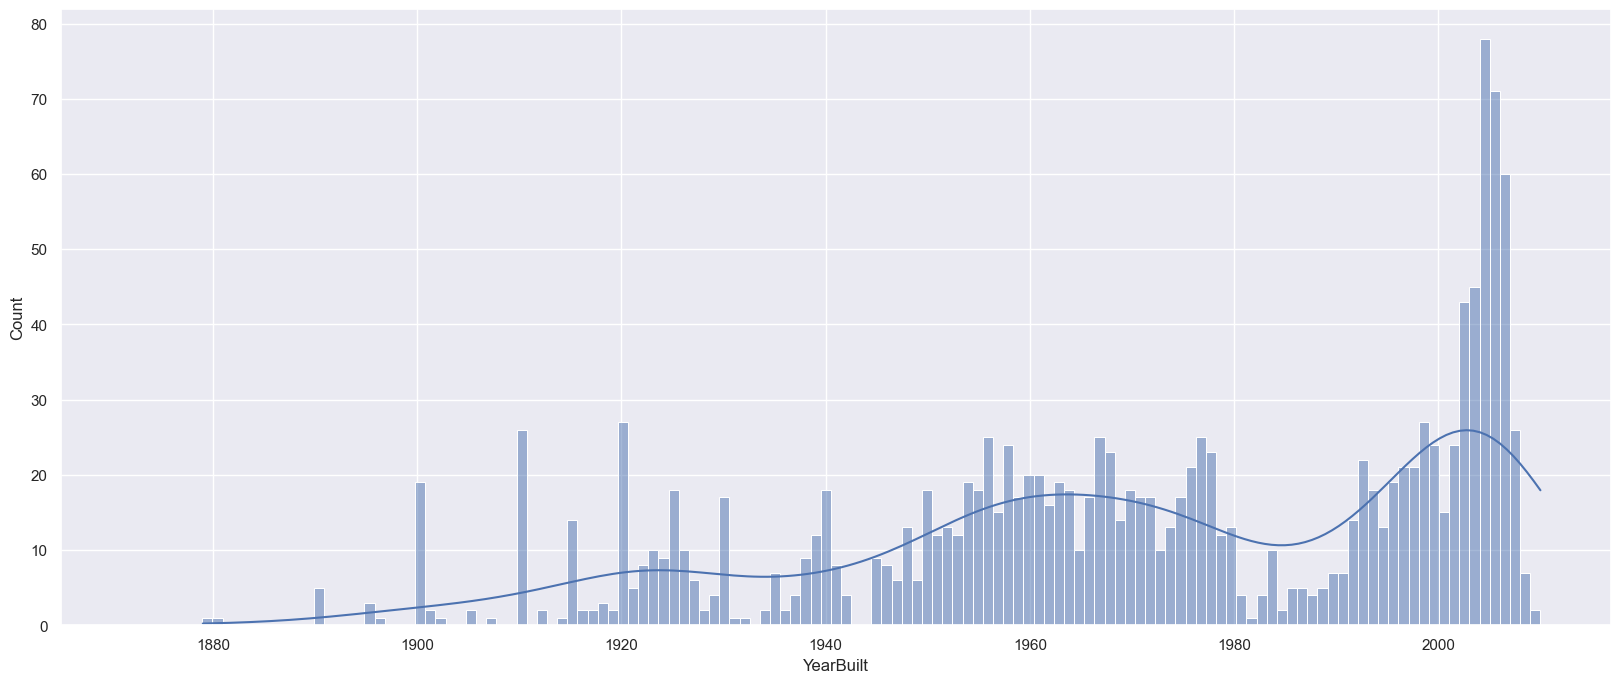

In [21]:
sns.set(rc = {'figure.figsize' : (20,8)})
sns.histplot(df_copy['YearBuilt'], kde=True, binrange=((1872, 2010)), bins = 139);

In [22]:
df_copy['GarageYrBlt'].describe()

count   1459.000
mean    1976.758
std       26.036
min     1895.000
25%     1958.500
50%     1977.000
75%     2001.000
max     2128.500
Name: GarageYrBlt, dtype: float64

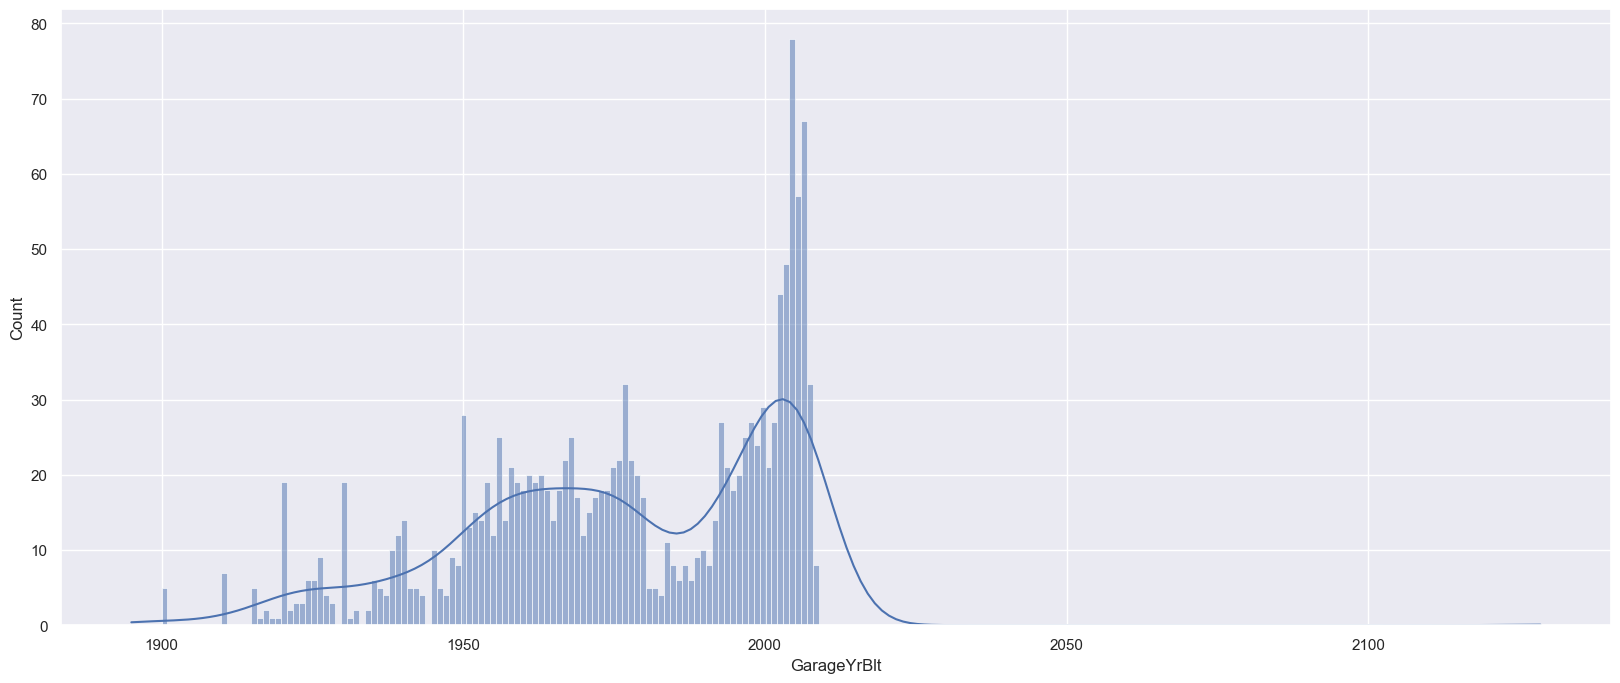

In [23]:
sns.set(rc = {'figure.figsize' : (20,8)})
sns.histplot(df_copy['GarageYrBlt'], kde=True, binrange=((1900, 2010)), bins = 111);

In [24]:
df_copy['YearRemodAdd'].describe()

count   1459.000
mean    1983.663
std       21.130
min     1950.000
25%     1963.000
50%     1992.000
75%     2004.000
max     2010.000
Name: YearRemodAdd, dtype: float64

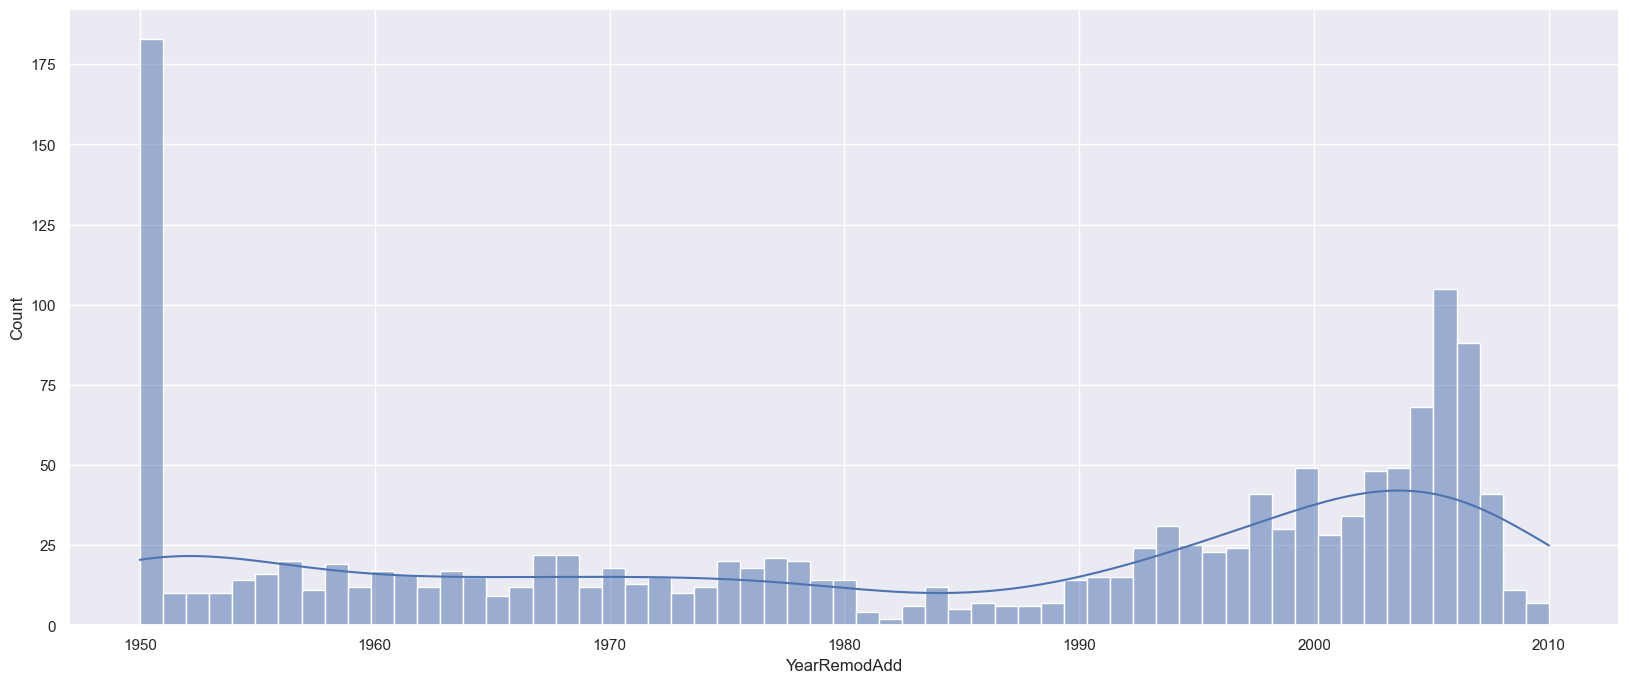

In [25]:
sns.set(rc = {'figure.figsize' : (20,8)})
sns.histplot(df_copy['YearRemodAdd'], kde=True, binrange=((1950, 2010)), bins = 61);

In [26]:
year_cols = ['YearRemodAdd', 'GarageYrBlt', 'YearBuilt']

cat_cols.extend(year_cols)
num_cols = [col for col in num_cols if col not in year_cols]

C:\Users\BORA\AppData\Local\Temp\ipykernel_5556\2821707075.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_copy['YearBuilt'], kde = True, bins = 139);


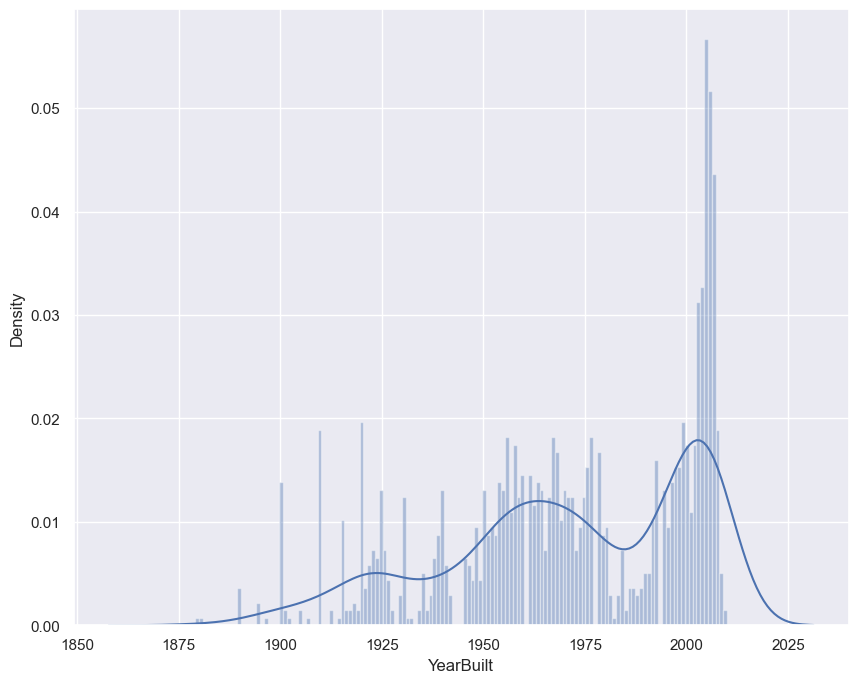

In [27]:
#DISTRIBUTION CURVE
sns.set(rc = {'figure.figsize' : (10,8)})
sns.distplot(df_copy['YearBuilt'], kde = True, bins = 139);